# Determine MSIDs reaching mission max/min temperatures duing 2023:044 Safe Mode Anomaly 

## Imports 

In [1]:
import os
os.environ['SKA_DATA'] = 'C:/Users/christian.anderson/Documents/MATLAB/FOT_Tools/Ska_data'

In [2]:
import json
import re
from urllib.request import urlopen
import pandas as pd
import requests
import numpy as np
import plotly.io as pio
import plotly.express as px
from cheta import fetch_eng
import Ska.engarchive.fetch_eng as fetch_eng2
import Chandra.Time
from cxotime import CxoTime

In [5]:
import sys
from os.path import expanduser

home = expanduser("~")
sys.path.append(home + "/AXAFLIB/pylimmon/")
import pylimmon


Using G_LIMMON DB Here:C:/Users/christian.anderson/Documents/MATLAB/FOT_Tools/Ska_data\glimmon_archive/
Using TDB Here:C:/Users/christian.anderson/Documents/MATLAB/FOT_Tools/Ska_data\fot_tdb_archive/


In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pio.renderers.default = "notebook"

## Local Function Definitions 

In [7]:
def maude_query(msid, t1, t2, all_points=True):
    # (base URL)/<CHANNEL>/<querytype>.<format>?<query options separated by &>
    # https://occweb.cfa.harvard.edu/maude/mrest/FLIGHT/msid.json?m=STAT_1DAY_MIN_OOBTHR18&ts=2015.001&tp=2016.001
    
    # All Points
    if all_points is True:
        # All Points
        base_url_constructor = 'https://occweb.cfa.harvard.edu/maude/mrest/FLIGHT/msid.json?m={}&ts={}&tp={}&ap=t'
    else:
        # Reduced Points
        base_url_constructor = 'https://occweb.cfa.harvard.edu/maude/mrest/FLIGHT/msid.json?m={}&ts={}&tp={}'

    url = base_url_constructor.format(msid.lower(), t1, t2)

    try:
        jsondata = requests.get(url).json()
        data = pd.DataFrame({'date':pd.to_datetime(jsondata['data-fmt-1']['times'], format='%Y%j%H%M%S%f'),
                       'data':jsondata['data-fmt-1']['values']})
        data["data"] = pd.to_numeric(data["data"])
    except:
        data = pd.DataFrame({'date':[None,], 'data':[None,]})

    return data


def ska_query(msid, t1, t2, stat='daily'):
    data = fetch_eng.Msid(msid, t1, t2, stat=stat)
    return pd.DataFrame({'date': data.times, 'data': data.vals})


def get_warning_low(msid):
    tdb_lim = pd.read_csv('C:/Users/christian.anderson/Documents/TDB_LIMIT.csv')
    
    for i in range(len(tdb_lim)):
        x = tdb_lim.at[i, 'MSID']
        
        if x == msid:
            warning_low = tdb_lim.at[i, 'WARNING_LOW']
        else:
            continue  
            
        return warning_low

    
def get_warning_high(msid):
    tdb_lim = pd.read_csv('C:/Users/christian.anderson/Documents/TDB_LIMIT.csv')
    
    for i in range(len(tdb_lim)):
        x = tdb_lim.at[i, 'MSID']
        
        if x == msid:
            warning_high = tdb_lim.at[i, 'WARNING_HIGH']    
        else:
            continue
            
        return warning_high
                

## TDB Limit Table (exported from Microsoft Access) 

In [8]:
tdb_lim = pd.read_csv('C:/Users/christian.anderson/Documents/Anomalies/2023/2023_44_Safe_Mode/TDB_LIMIT.csv')
tdb_lim

,MSID,LIMIT_SET_NUM,CAUTION_LOW,CAUTION_HIGH,WARNING_LOW,WARNING_HIGH,DELTA,TOLER,EM_ALL_SAMP_FLAG
0,1MAHCAT,1,210.000,998.000,200.000,999.000,NaN,5,A
1,1MAHCBT,1,210.000,998.000,200.000,999.000,NaN,5,A
2,1MAHOAT,1,210.000,998.000,200.000,999.000,NaN,5,A
3,1MAHOBT,1,210.000,998.000,200.000,999.000,NaN,5,A
4,1VAHCAT,1,210.000,998.000,200.000,999.000,NaN,5,A
...,...,...,...,...,...,...,...,...,...
1490,2PRBSCR,1,1.239,2.057,0.898,2.262,NaN,5,A
1491,PLINE04T,1,42.500,180.000,39.500,240.000,NaN,5,A
1492,PMFP01T,1,47.000,150.000,40.000,170.000,NaN,5,A
1493,TMZP_MY,1,-45.000,175.000,-50.000,230.000,NaN,5,A


## Read in Thermal MSID List 

In [9]:
therm_list = pd.read_csv('//noodle/greta/mdahmer/AXAFDATA/weekly_report_data/thermlist.csv')
therm_list

,greta_msid,ska_msid,owner,description
0,1CBAT,1CBAT,acis,camera body temp. a
1,1CBBT,1CBBT,acis,camera body temp. b
2,1CRAT,1CRAT,acis,cold radiator temp. a
3,1CRBT,1CRBT,acis,cold radiator temp. b
4,1DACTBT,1DACTBT,acis,da collimator-top temp. b
...,...,...,...,...
1033,TABMIN,TABMIN,not in tdb,not in tdb
1034,THSMAX,THSMAX,not in tdb,not in tdb
1035,THSMIN,THSMIN,not in tdb,not in tdb
1036,TSSMAX,TSSMAX,not in tdb,not in tdb


## Filter out non-numerical MSIDs 

In [10]:
# Extract the "ska_msids"
thermal_MSIDs = therm_list.iloc[:,1]
msids = [v.strip() for v in thermal_MSIDs.values if 'None' not in v]
t1 = '2000:200:00:00:00.000' 
t2 = '2023:051:00:00:00.000'

# List of numeric MSIDs
num_msid = []
# List of the numeric values
num_vals = []

for msid in msids:
    data = fetch_eng.Msid(msid, t1, t2, stat='daily')
    max_temp = max(data.vals)
        
        
    # consider modifying float32 to account for more general cases
    if isinstance(max_temp, np.float32) == True:
        num_vals.append(max_temp)
        num_msid.append(msid)  #these are the  msids with numerical values (not states)
        
    else:
        continue
        
print(num_msid)    


['1CBAT', '1CBBT', '1CRAT', '1CRBT', '1DACTBT', '1DAHACU', '1DAHAT', '1DAHAVO', '1DAHBCU', '1DAHBT', '1DAHBVO', '1DAHHAVO', '1DAHHBVO', '1DEAMZT', '1DPAMYT', '1DPAMZT', '1MAHCAT', '1MAHCBT', '1MAHOAT', '1MAHOBT', '1OAHAT', '1OAHBT', '1PDEAAT', '1PDEABT', '1PIN1AT', '1VAHCAT', '1VAHCBT', '1VAHOAT', '1VAHOBT', '1WRAT', '1WRBT', '2CEAHVPT', '2CHTRPZT', '2CONDMXT', '2DCENTRT', '2DTSTATT', '2FEPRATM', '2FHTRMZT', '2FRADPYT', '2IMHVATM', '2IMINATM', '2LVPLATM', '2PMT1T', '2PMT2T', '2SMTRATM', '2SPHVATM', '2SPINATM', '2UVLSPXT', '3BTU_BPT', '3FABRAAT', '3FABRCAT', '3FAFLAAT', '3FAFLBAT', '3FAFLCAT', '3FAMTRAT', '3FAMYZAT', '3FAPSAT', '3FAPYZAT', '3FARALAT', '3FASEAAT', '3FLCABPT', '3RCTUBPT', '3SFLXAST', '3SFLXBST', '3SFLXCST', '3TRMTRAT', '3TSMXCET', '3TSMXSPT', '3TSMYDPT', '3TSPYFET', '3TSPZDET', '3TSPZSPT', '3TTACS1T', '3TTACS2T', '3TTACS3T', '3TTBRGBT', '3TTHRC1T', '3TTHRC2T', '3TTHRC3T', '3TTRALAT', '3TTRALCT', '3TTVALVT', '4ALL1AT', '4ALL1BT', '4ALL2AT', '4ALL2BT', '4HFSPAT', '4HFSPBT',

## Determine If max/min occurred during anomaly 

In [11]:
# Safe Mode Anomaly Time Range
t_anom_start = Chandra.Time.DateTime('2023:044:17:41:00').secs
t_anom_stop = Chandra.Time.DateTime('2023:055:00:00:00').secs

# Data for numeric MSIDs
data_num = {}

# List of MSIDs achieving max temperatures during anomaly:
msid_anom_max = []
msid_anom_min = []
anom_max_df = pd.DataFrame(columns=['MSID', 'Technical Name', 'Max Temp', 'Units', 'Caution High', 'Warning High', 'Time of Max'])
anom_min_df = pd.DataFrame(columns=['MSID', 'Technical Name', 'Min Temp', 'Units', 'Caution Low', 'Warning Low', 'Time  of Min'])


# Iterate through numeric MSIDs
for m in num_msid:
    fetch_eng.data_source.set('cxc')
    data_num[m] = fetch_eng.Msid(m, t1, t2,stat="5min")
    data_num[m].filter_bad(copy=True)
   

    # Technical Name
    try: 
        tech_name = data_num[m].tdb.technical_name
        
    except KeyError:
        tech_name = "Not in TDB"
       
    
    # Units
    try:
        units = data_num[m].unit
        print(units)
    except KeyError:
        units = "None Found"
     
    
    # Limits
    try:    
        safety_limits = pylimmon.get_mission_safety_limits(m)
        
    except IndexError:
        safety_limits = None
    
    if safety_limits:
        current_warning_high = safety_limits["warning_high"][-1]
        current_warning_low  = safety_limits["warning_low"][-1]
        current_caution_high = safety_limits["caution_high"][-1]
        current_caution_low  = safety_limits["caution_low"][-1]
        print(m, 'tdb warning high is:',current_warning_high, 'tdb caution high is', current_caution_high)

    elif safety_limits is None:
        
        try:
            current_warning_high = pylimmon.get_latest_glimmon_limits(m)["warning_high"]
            current_warning_low = pylimmon.get_latest_glimmon_limits(m)["warning_low"]
            current_caution_high = pylimmon.get_latest_glimmon_limits(m)["caution_high"]
            current_caution_low = pylimmon.get_latest_glimmon_limits(m)["caution_low"]
            print(m, 'glimmon warning high is:',current_warning_high, 'glimmon caution high is:', current_caution_high)
            
        except TypeError:
            current_warning_high = 9999
            current_warning_low  = -9999
            current_caution_high = 9999
            current_caution_low = -9999
    
    else:
        print('no tdb or glimmon limits for:', msid_anom)
    
    
    print(m, "-->", "CH =", current_caution_high, ' ', "WH = ", current_warning_high)
    
    
    # Spacecraft Mode Transition Filters
    pad = 300 # seconds
    ind1 = data_num[m].times < (CxoTime('2022:293:16:27:49.000').secs - pad) # 2023:293 Safe Mode transition
    ind2 = data_num[m].times > (CxoTime('2022:293:16:27:49.000').secs + pad)
    ind3 = data_num[m].times < (CxoTime('2023:044:17:41:07.000').secs - pad) # 2023:044 Safe Mode transition 
    ind4 = data_num[m].times > (CxoTime('2023:044:17:41:07.000').secs + pad)
    ind5 = data_num[m].times < (CxoTime('2023:045:03:32:39.000').secs - pad) # 2023:045 Swap to CTU-A
    ind6 = data_num[m].times > (CxoTime('2023:045:03:32:39.000').secs + pad)
    ind7 = data_num[m].times < (CxoTime('2023:047:07:33:47.000').secs - pad) # 2023:047 Safe Mode transition
    ind8 = data_num[m].times > (CxoTime('2023:047:07:33:47.000').secs + pad)
    ind9 = data_num[m].times < (CxoTime('2023:048:03:17:11.000').secs - pad) # 2023:048 Swap to CTU-A
    ind10 = data_num[m].times > (CxoTime('2023:048:03:17:11.000').secs + pad)
    good_ind_1 = ind1 | ind2
    good_ind_2 = ind3 | ind4
    good_ind_3 = ind5 | ind6
    good_ind_4 = ind7 | ind8
    good_ind_5 = ind9 | ind10
    good_ind_6 = data_num[m].vals < 250
    
    # Thermal Control Disable Filters
    pad2 = 70 # seconds
    ind11 = data_num[m].times < (CxoTime('2023:045:03:29:49.010').secs - pad2) # 2023:045 Thermal Control Disabled
    ind12 = data_num[m].times > (CxoTime('2023:045:04:48:37.150').secs + pad2)
    ind13 = data_num[m].times < (CxoTime('2023:047:07:33:33.163').secs - pad2) # 2023:047 Thermal Control Disabled
    ind14 = data_num[m].times > (CxoTime('2023:047:07:34:48.125').secs + pad2)
    ind15 = data_num[m].times < (CxoTime('2023:048:03:14:30.531').secs - pad2) # 2023:048 Thermal Control Disabled
    ind16 = data_num[m].times > (CxoTime('2023:048:03:56:31.086').secs + pad2)
    good_ind_7 = ind11 | ind12
    good_ind_8 = ind13 | ind14
    good_ind_9 = ind15 | ind16
     
    good_ind_all = good_ind_1 & good_ind_2 & good_ind_3 & good_ind_4 & good_ind_5 & good_ind_6 & good_ind_7 & good_ind_8 & good_ind_9
  

    # Max temps
    try:
        max_t_array = data_num[m].maxes[good_ind_all]       # array of max temps @ every 5-min interval
        max_t = max(max_t_array)                            # max temp value over entire mission
    except ValueError as msg:
        # add message
        print()
        continue
    index_max = np.argmax(max_t_array)                      # index of mission high
    time_of_max = data_num[m].times[index_max]              # time of mission high
    time_of_max_1 = Chandra.Time.secs2date(time_of_max)
    
    print('max temp =', max_t, '---', 'time of max =', time_of_max_1)
    
    # Min temps
    try:
        min_t_array = data_num[m].mins[good_ind_all]
        min_t = min(min_t_array)
    except ValueError:
        continue
    index_min = np.argmin(min_t_array)
    time_of_min = data_num[m].times[index_min]
    time_of_min_1 = Chandra.Time.secs2date(time_of_min)
    
    
    # If mission max temp occurred during anomaly, append to "anom_max_df"
    if (time_of_max > t_anom_start) and (time_of_max < t_anom_stop):
        msid_anom_max.append(m)
        anom_max_df.loc[len(anom_max_df)] = [m, tech_name, max_t, units, current_caution_high, current_warning_high,  time_of_max_1]
    
    # If mission min temp occurred during anomaly, append to "anom_min_df"
    elif (time_of_min > t_anom_start) and (time_of_min < t_anom_stop):
        msid_anom_min.append(m)
        anom_min_df.loc[len(anom_min_df)] = [m, tech_name, min_t, units, current_caution_high, current_warning_high, time_of_min_1]
        
    else:
        continue

print(msid_anom_max)
print(len(anom_max_df.iloc[:,0]))


DEGC
1CBAT tdb warning high is: -50.0 tdb caution high is -52.0
1CBAT --> CH = -52.0   WH =  -50.0
max temp = -54.95279 --- time of max = 2022:059:14:59:34.816


DEGC
1CBBT tdb warning high is: -50.0 tdb caution high is -52.0
1CBBT --> CH = -52.0   WH =  -50.0
max temp = -54.95279 --- time of max = 2022:059:14:37:42.816
DEGC
1CRAT tdb warning high is: -80.0 tdb caution high is -90.0
1CRAT --> CH = -90.0   WH =  -80.0
max temp = -82.00232 --- time of max = 2022:128:09:00:54.816
DEGC
1CRBT tdb warning high is: -80.0 tdb caution high is -90.0
1CRBT --> CH = -90.0   WH =  -80.0
max temp = 2.5644226 --- time of max = 2012:151:10:34:33.816
DEGC
1DACTBT tdb warning high is: 5.0 tdb caution high is 0.0
1DACTBT --> CH = 0.0   WH =  5.0
max temp = -2.484314 --- time of max = 2022:069:21:59:42.816
AMP
1DAHACU tdb warning high is: 999.0 tdb caution high is 0.16
1DAHACU --> CH = 0.16   WH =  999.0
max temp = 0.54 --- time of max = 2012:151:10:34:33.816
None
1DAHAT does not have limits in TDB version P009
1DAHAT does not have limits in TDB version P010
1DAHAT does not have limits in TDB version P011
1DAHAT does not have limits in TDB version P012
1DAHAT does

DEGC
3FABRCAT tdb warning high is: 80.0 tdb caution high is 50.0
3FABRCAT --> CH = 50.0   WH =  80.0
max temp = 25.333282 --- time of max = 2019:248:09:37:26.816
DEGC
3FAFLAAT tdb warning high is: 24.0 tdb caution high is 20.0
3FAFLAAT --> CH = 20.0   WH =  24.0
max temp = 19.600006 --- time of max = 2022:047:19:54:38.816
DEGC
3FAFLBAT tdb warning high is: 24.0 tdb caution high is 20.0
3FAFLBAT --> CH = 20.0   WH =  24.0
max temp = 13.600006 --- time of max = 2023:049:04:51:42.816
DEGC
3FAFLCAT tdb warning high is: 35.0 tdb caution high is 30.0
3FAFLCAT --> CH = 30.0   WH =  35.0
max temp = 25.399994 --- time of max = 2000:212:04:17:39.816
DEGC
3FAMTRAT tdb warning high is: 50.0 tdb caution high is 45.0
3FAMTRAT --> CH = 45.0   WH =  50.0
max temp = 20.5 --- time of max = 2022:047:21:05:42.816
DEGC
3FAMYZAT tdb warning high is: 80.0 tdb caution high is 50.0
3FAMYZAT --> CH = 50.0   WH =  80.0
max temp = 36.260284 --- time of max = 2004:136:21:29:23.816
DEGC
3FAPSAT tdb warning high is:

DEGF
4PRT1BT tdb warning high is: 1100.0 tdb caution high is 1099.0
4PRT1BT --> CH = 1099.0   WH =  1100.0
max temp = -77.22287 --- time of max = 2016:065:18:29:27.816
DEGF
4PRT2AT tdb warning high is: 95.0 tdb caution high is 62.5
4PRT2AT --> CH = 62.5   WH =  95.0
max temp = -53.99411 --- time of max = 2011:343:12:38:49.816
DEGF
4PRT2BT tdb warning high is: 1100.0 tdb caution high is 1099.0
4PRT2BT --> CH = 1099.0   WH =  1100.0
max temp = -78.252655 --- time of max = 2016:065:18:29:27.816
DEGF
4PRT3AT tdb warning high is: 95.0 tdb caution high is 62.5
4PRT3AT --> CH = 62.5   WH =  95.0
max temp = 9.207672 --- time of max = 2011:282:18:08:25.816
DEGF
4PRT3BT tdb warning high is: 1100.0 tdb caution high is 1099.0
4PRT3BT --> CH = 1099.0   WH =  1100.0
max temp = 4.349243 --- time of max = 2016:065:18:34:55.816
DEGF
4PRT4AT tdb warning high is: 95.0 tdb caution high is 62.5
4PRT4AT --> CH = 62.5   WH =  95.0
max temp = -48.558044 --- time of max = 2011:306:12:02:25.816
DEGF
4PRT4BT tdb

DEGF
AACBPRT does not have limits in TDB version P007
AACBPRT does not have limits in TDB version P009
AACBPRT does not have limits in TDB version P010
AACBPRT does not have limits in TDB version P011
AACBPRT does not have limits in TDB version P012
AACBPRT does not have limits in TDB version P013
AACBPRT does not have limits in TDB version P014
AACBPRT does not have limits in TDB version P015
AACBPRT does not have limits in TDB version P016
AACBPRT glimmon warning high is: 116.0 glimmon caution high is: 109.0
AACBPRT --> CH = 109.0   WH =  116.0
max temp = 368.83994 --- time of max = 2011:299:05:00:57.816
DEGF
AACCCDPT does not have limits in TDB version P007
AACCCDPT does not have limits in TDB version P009
AACCCDPT does not have limits in TDB version P010
AACCCDPT does not have limits in TDB version P011
AACCCDPT does not have limits in TDB version P012
AACCCDPT does not have limits in TDB version P013
AACCCDPT does not have limits in TDB version P014
AACCCDPT does not have limits i

EOESAT2C tdb warning high is: 200.0 tdb caution high is 167.0
EOESAT2C --> CH = 167.0   WH =  200.0
max temp = 395.19992 --- time of max = 2001:004:09:04:35.816
None
EOTB1T1C tdb warning high is: 106.0 tdb caution high is 86.0
EOTB1T1C --> CH = 86.0   WH =  106.0
max temp = 106.35 --- time of max = 2001:008:23:24:43.816
None
EOTB1T2C tdb warning high is: 106.0 tdb caution high is 86.0
EOTB1T2C --> CH = 86.0   WH =  106.0
max temp = 106.35 --- time of max = 2001:008:23:24:43.816
None
EOTB1T3C tdb warning high is: 106.0 tdb caution high is 86.0
EOTB1T3C --> CH = 86.0   WH =  106.0
max temp = 38.27495 --- time of max = 2010:150:06:12:41.816
None
EOTB2T1C tdb warning high is: 77.9 tdb caution high is 74.3
EOTB2T1C --> CH = 74.3   WH =  77.9
max temp = 42.200085 --- time of max = 2008:292:22:48:50.816
None
EOTB2T2C tdb warning high is: 77.9 tdb caution high is 74.3
EOTB2T2C --> CH = 74.3   WH =  77.9
max temp = 42.63621 --- time of max = 2008:292:22:48:50.816
None
EOTB2T3C tdb warning high 

DEGF
PM1THV1T tdb warning high is: 240.0 tdb caution high is 220.0
PM1THV1T --> CH = 220.0   WH =  240.0
max temp = 217.23013 --- time of max = 2021:033:21:17:26.816
DEGF
PM1THV2T tdb warning high is: 240.0 tdb caution high is 220.0
PM1THV2T --> CH = 220.0   WH =  240.0
max temp = 215.53818 --- time of max = 2021:033:22:06:38.816
DEGF
PM2THV1T tdb warning high is: 240.0 tdb caution high is 220.0
PM2THV1T --> CH = 220.0   WH =  240.0
max temp = 226.48868 --- time of max = 2022:295:17:49:50.816
DEGF
PM2THV2T tdb warning high is: 240.0 tdb caution high is 220.0
PM2THV2T --> CH = 220.0   WH =  240.0
max temp = 218.92209 --- time of max = 2023:049:01:07:34.816
DEGF
PM3THV1T tdb warning high is: 240.0 tdb caution high is 120.0
PM3THV1T --> CH = 120.0   WH =  240.0
max temp = 111.59451 --- time of max = 2001:202:21:32:59.816
DEGF
PM3THV2T tdb warning high is: 240.0 tdb caution high is 120.0
PM3THV2T --> CH = 120.0   WH =  240.0
max temp = 104.67795 --- time of max = 2001:243:01:52:11.816
DEGF

DEGF
TB2T3 tdb warning high is: 106.0 tdb caution high is 86.0
TB2T3 --> CH = 86.0   WH =  106.0
max temp = 42.6362 --- time of max = 2012:151:14:13:13.816
DEGF
TB3T1 tdb warning high is: 106.0 tdb caution high is 86.0
TB3T1 --> CH = 86.0   WH =  106.0
max temp = 59.435944 --- time of max = 2022:276:03:19:58.816
DEGF
TB3T2 tdb warning high is: 106.0 tdb caution high is 86.0
TB3T2 --> CH = 86.0   WH =  106.0
max temp = 42.6362 --- time of max = 2011:046:14:01:37.816
DEGF
TB3T3 tdb warning high is: 106.0 tdb caution high is 86.0
TB3T3 --> CH = 86.0   WH =  106.0
max temp = 313.41995 --- time of max = 2011:299:05:00:57.816
DEGF
TBOLTCUT tdb warning high is: 1100.0 tdb caution high is 1099.0
TBOLTCUT --> CH = 1099.0   WH =  1100.0
max temp = 104.889984 --- time of max = 2015:303:16:05:27.816
DEGF
TCM_CTU tdb warning high is: 131.0 tdb caution high is 126.0
TCM_CTU --> CH = 126.0   WH =  131.0
max temp = 101.1301 --- time of max = 2022:296:21:26:14.816
DEGF
TCM_IFU tdb warning high is: 131.

DEGF
TFUTSUPN tdb warning high is: 170.0 tdb caution high is 165.0
TFUTSUPN --> CH = 165.0   WH =  170.0
max temp = 141.50198 --- time of max = 2023:048:01:20:46.816
DEGF
TMYHNG tdb warning high is: 1100.0 tdb caution high is 1099.0
TMYHNG --> CH = 1099.0   WH =  1100.0
max temp = -14.762634 --- time of max = 2020:033:14:53:26.816
DEGF
TMYSADA tdb warning high is: 131.0 tdb caution high is 126.0
TMYSADA --> CH = 126.0   WH =  131.0
max temp = 215.03 --- time of max = 2011:190:19:47:37.816
DEGF
TMZLGABM tdb warning high is: 239.0 tdb caution high is 234.0
TMZLGABM --> CH = 234.0   WH =  239.0
max temp = 161.29794 --- time of max = 2022:297:02:26:54.816
DEGF
TMZP_CNT tdb warning high is: 230.0 tdb caution high is 228.0
TMZP_CNT --> CH = 228.0   WH =  230.0
max temp = 229.97275 --- time of max = 2023:046:04:36:38.816
DEGF
TMZP_MY tdb warning high is: 230.0 tdb caution high is 180.0
TMZP_MY --> CH = 180.0   WH =  230.0
max temp = 175.43796 --- time of max = 2023:047:00:01:02.816
DEGF
TMZP_

DEGF
4RT560T tdb warning high is: 95.0 tdb caution high is 86.0
4RT560T --> CH = 86.0   WH =  95.0
max temp = 152.65646 --- time of max = 2016:066:18:43:35.816
DEGF
4RT561T tdb warning high is: 95.0 tdb caution high is 86.0
4RT561T --> CH = 86.0   WH =  95.0
max temp = 152.65646 --- time of max = 2016:066:18:43:35.816
DEGF
4RT562T tdb warning high is: 95.0 tdb caution high is 86.0
4RT562T --> CH = 86.0   WH =  95.0
max temp = 152.65646 --- time of max = 2016:066:18:43:35.816
DEGF
4RT563T tdb warning high is: 95.0 tdb caution high is 86.0
4RT563T --> CH = 86.0   WH =  95.0
max temp = 152.65646 --- time of max = 2016:066:18:43:35.816
DEGF
4RT565T tdb warning high is: 95.0 tdb caution high is 86.0
4RT565T --> CH = 86.0   WH =  95.0
max temp = 152.65646 --- time of max = 2016:066:18:43:35.816
DEGF
4RT567T tdb warning high is: 95.0 tdb caution high is 86.0
4RT567T --> CH = 86.0   WH =  95.0
max temp = 152.65646 --- time of max = 2016:066:18:43:35.816
DEGF
4RT568T tdb warning high is: 95.0 t

DEGF
OHRTHR09 tdb warning high is: 95.0 tdb caution high is 78.5
OHRTHR09 --> CH = 78.5   WH =  95.0
max temp = 78.54941 --- time of max = 2023:049:13:58:22.816
DEGF
OHRTHR10 tdb warning high is: 95.0 tdb caution high is 78.5
OHRTHR10 --> CH = 78.5   WH =  95.0
max temp = 77.58127 --- time of max = 2023:049:16:31:26.816
DEGF
OHRTHR11 tdb warning high is: 95.0 tdb caution high is 78.5
OHRTHR11 --> CH = 78.5   WH =  95.0
max temp = 77.65091 --- time of max = 2023:049:21:10:14.816
DEGF
OHRTHR12 tdb warning high is: 95.0 tdb caution high is 78.5
OHRTHR12 --> CH = 78.5   WH =  95.0
max temp = 79.176605 --- time of max = 2023:049:11:36:14.816
DEGF
OHRTHR13 tdb warning high is: 95.0 tdb caution high is 78.5
OHRTHR13 --> CH = 78.5   WH =  95.0
max temp = 79.23245 --- time of max = 2023:049:13:09:10.816
DEGF
OHRTHR14 tdb warning high is: 95.0 tdb caution high is 78.5
OHRTHR14 --> CH = 78.5   WH =  95.0
max temp = 81.05759 --- time of max = 2023:048:06:59:42.816
DEGF
OHRTHR15 tdb warning high is

None
OOBAGRD4 tdb warning high is: 616.0 tdb caution high is 609.0
OOBAGRD4 --> CH = 609.0   WH =  616.0
max temp = 601.0 --- time of max = 2000:200:01:11:39.816
None
OOBAGRD5 tdb warning high is: 437.0 tdb caution high is 430.0
OOBAGRD5 --> CH = 430.0   WH =  437.0
max temp = 602.0 --- time of max = 2000:200:03:44:43.816
DEGF
OOBAGRD6 tdb warning high is: 2.5 tdb caution high is 0.3
OOBAGRD6 --> CH = 0.3   WH =  2.5
max temp = 421.42233 --- time of max = 2016:064:01:13:03.816
None
OOBAGRD7 tdb warning high is: 259.0 tdb caution high is 252.0
OOBAGRD7 --> CH = 252.0   WH =  259.0
max temp = 642.0 --- time of max = 2018:285:12:54:14.816
None
OOBAGRD8 tdb warning high is: 78.0 tdb caution high is 71.0
OOBAGRD8 --> CH = 71.0   WH =  78.0
max temp = 930.0 --- time of max = 2008:225:09:24:02.816
None
POBAT --> CH = 9999   WH =  9999
max temp = 675.71466 --- time of max = 2000:262:16:15:15.816
DEGF
OOBTHR02 tdb warning high is: 95.0 tdb caution high is 86.0
OOBTHR02 --> CH = 86.0   WH =  95.

DEGF
OOBTHR50 tdb warning high is: 140.0 tdb caution high is 110.0
OOBTHR50 --> CH = 110.0   WH =  140.0
max temp = 143.46902 --- time of max = 2018:285:13:10:38.816
DEGF
OOBTHR51 tdb warning high is: 140.0 tdb caution high is 110.0
OOBTHR51 --> CH = 110.0   WH =  140.0
max temp = 143.46902 --- time of max = 2018:285:13:10:38.816
DEGF
OOBTHR52 tdb warning high is: 140.0 tdb caution high is 110.0
OOBTHR52 --> CH = 110.0   WH =  140.0
max temp = 123.33145 --- time of max = 2023:049:04:57:10.816
DEGF
OOBTHR53 tdb warning high is: 140.0 tdb caution high is 110.0
OOBTHR53 --> CH = 110.0   WH =  140.0
max temp = 143.46902 --- time of max = 2018:285:13:10:38.816
DEGF
OOBTHR54 tdb warning high is: 140.0 tdb caution high is 110.0
OOBTHR54 --> CH = 110.0   WH =  140.0
max temp = 143.46902 --- time of max = 2018:285:13:10:38.816
DEGF
OOBTHR55 tdb warning high is: 140.0 tdb caution high is 115.0
OOBTHR55 --> CH = 115.0   WH =  140.0
max temp = 143.46902 --- time of max = 2018:285:13:10:38.816
DEGF

#### Anomaly Mission Max Table: 

In [21]:
pd.set_option('display.max_rows', None)
anom_max_df

,MSID,Technical Name,Max Temp,Units,Caution High,Warning High,Time of Max
0,3FAFLBAT,SEA FA FLEXURE B TEMP A,13.600006,DEGC,20.0,24.0,2023:049:04:51:42.816
1,4OAVOBAT,AVERAGE TEMPERATURE OF OBA SYSTEM,102.155853,DEGF,115.0,140.0,2023:049:01:34:54.816
2,5EPHINT,EPHIN TEMP,86.551758,DEGC,90.0,999.0,2023:048:01:20:46.816
3,AACBPPT,AC BASEPLATE TEMP (PRIME),121.875458,DEGF,117.0,124.0,2023:047:02:12:14.816
4,AACCCDPT,AC CCD TEMP (PRI),114.414886,DEGF,30.0,37.0,2023:047:05:50:54.816
5,AACCCDRT,AC CCD TEMP (RDNT),115.451935,DEGF,110.0,117.0,2023:046:20:05:58.816
6,AACH1T,AC HOUSING TEMP (ACH1),111.303741,DEGF,100.0,109.0,2023:046:20:00:30.816
7,AAOTAPMT,AC OPT TEL ASSY PRIMARY MIRROR TEMP,109.229645,DEGF,103.0,111.0,2023:046:21:55:18.816
8,AAOTASMT,AC OPT TEL ASSY SECONDARY MIRROR TEMP,109.229645,DEGF,104.0,111.0,2023:046:19:49:34.816
9,AAOTH2MT,AC OPT TEL ASSY SECONDARY MIRROR TEMP (HRMA),110.266693,DEGF,105.0,112.0,2023:046:19:16:46.816


#### Anomaly Mission Min Table: 

In [18]:
anom_min_df

,MSID,Technical Name,Min Temp,Units,Caution Low,Warning Low,Time of Min


In [41]:
# Write Dataframe to .csv
anom_max_df.to_csv('C:/Users/christian.anderson/Documents/Anomalies/2023/2023_44_Safe_Mode/max_min_data/2023_044_anomaly_mission_maxes_v3.csv')
anom_min_df.to_csv('C:/Users/christian.anderson/Documents/Anomalies/2023/2023_44_Safe_Mode/max_min_data/2023_044_anomaly_mission_mins.csv')

# Limit Violation Data

In [22]:
# Safe Mode Anomaly Time Range
t_anom_start = Chandra.Time.DateTime('2023:044:17:41:00').secs
t_anom_stop = Chandra.Time.DateTime('2023:055:00:00:00').secs

warning_limit_violations = pd.DataFrame(columns=['MSID', 'Technical Name', 'Max Temp', 'Units', 'Warning High', 'Time Spent Above Limit (Hours)'])
caution_limit_violations = pd.DataFrame(columns=['MSID', 'Technical Name', 'Max Temp', 'Units', 'Caution High', 'Time Spent Above Limit (Hours)'])

data_anomaly = {}

for msid_anom in num_msid:
    fetch_eng.data_source.set('maude') #cxc
    # when pulling from ska, default is 5min. For full res, stat=None
    data_anomaly[msid_anom] = fetch_eng.Msid(msid_anom, t_anom_start, t_anom_stop)
    data_anomaly[msid_anom].filter_bad(copy=True)
    
    print(msid_anom)
    
    # Technical Name
    try: 
        tech_name = data_anomaly[msid_anom].tdb.technical_name
        
    except KeyError:
        tech_name = "Not in TDB"
       
    
    # Units
    try:
        units = data_anomaly[msid_anom].unit
        print(units)
    except KeyError:
        units = "None Found"
    

    # Limits
    try:    
        safety_limits = pylimmon.get_mission_safety_limits(msid_anom)
    
    except IndexError:
        safety_limits = None
    
    
    if safety_limits:
        current_warning_high = safety_limits["warning_high"][-1]
        current_warning_low  = safety_limits["warning_low"][-1]
        current_caution_high = safety_limits["caution_high"][-1]
        current_caution_low  = safety_limits["caution_low"][-1]
        print(msid_anom, 'tdb warning high is:',current_warning_high, 'tdb caution high is', current_caution_high)

    elif safety_limits is None:
        
        try:
            current_warning_high = pylimmon.get_latest_glimmon_limits(msid_anom)["warning_high"]
            current_warning_low  = pylimmon.get_latest_glimmon_limits(msid_anom)["warning_low"]
            current_caution_high = pylimmon.get_latest_glimmon_limits(msid_anom)["caution_high"]
            current_caution_low = pylimmon.get_latest_glimmon_limits(msid_anom)["caution_low"]
            print(msid_anom, 'glimmon warning high is:',current_warning_high, 'glimmon caution high is:', current_caution_high)
            
        except TypeError:
            # add message
            current_warning_high = 9999
            current_warning_low  = -9999
            current_caution_high = 9999
            current_caution_low = -9999
    
    else:
        print('no tdb or glimmon limits for:', msid_anom)
    
    
    # Spacecraft Mode Transition Filters
    pad = 300 # seconds
    ind1 = data_anomaly[msid_anom].times < (CxoTime('2022:293:16:27:49.000').secs - pad) # 2023:293 Safe Mode transition
    ind2 = data_anomaly[msid_anom].times > (CxoTime('2022:293:16:27:49.000').secs + pad)
    ind3 = data_anomaly[msid_anom].times < (CxoTime('2023:044:17:41:07.000').secs - pad) # 2023:044 Safe Mode transition 
    ind4 = data_anomaly[msid_anom].times > (CxoTime('2023:044:17:41:07.000').secs + pad)
    ind5 = data_anomaly[msid_anom].times < (CxoTime('2023:045:03:32:39.000').secs - pad) # 2023:045 Swap to CTU-A
    ind6 = data_anomaly[msid_anom].times > (CxoTime('2023:045:03:32:39.000').secs + pad)
    ind7 = data_anomaly[msid_anom].times < (CxoTime('2023:047:07:33:47.000').secs - pad) # 2023:047 Safe Mode transition
    ind8 = data_anomaly[msid_anom].times > (CxoTime('2023:047:07:33:47.000').secs + pad)
    ind9 = data_anomaly[msid_anom].times < (CxoTime('2023:048:03:17:11.000').secs - pad) # 2023:048 Swap to CTU-A
    ind10 = data_anomaly[msid_anom].times > (CxoTime('2023:048:03:17:11.000').secs + pad)
    good_ind_1 = ind1 | ind2
    good_ind_2 = ind3 | ind4
    good_ind_3 = ind5 | ind6
    good_ind_4 = ind7 | ind8
    good_ind_5 = ind9 | ind10
    good_ind_6 = data_anomaly[msid_anom].vals < 250
    
    # Thermal Control Swap Filters
    pad2 = 70 # seconds
    ind11 = data_anomaly[msid_anom].times < (CxoTime('2023:045:03:29:49.010').secs - pad2) # 2023:045 Thermal Control Disabled
    ind12 = data_anomaly[msid_anom].times > (CxoTime('2023:045:04:48:37.150').secs + pad2)
    ind13 = data_anomaly[msid_anom].times < (CxoTime('2023:047:07:33:33.163').secs - pad2) # 2023:047 Thermal Control Disabled
    ind14 = data_anomaly[msid_anom].times > (CxoTime('2023:047:07:34:48.125').secs + pad2)
    ind15 = data_anomaly[msid_anom].times < (CxoTime('2023:048:03:14:30.531').secs - pad2) # 2023:048 Thermal Control Disabled
    ind16 = data_anomaly[msid_anom].times > (CxoTime('2023:048:03:56:31.086').secs + pad2)
    good_ind_7 = ind11 | ind12
    good_ind_8 = ind13 | ind14
    good_ind_9 = ind15 | ind16
     
    all_good_ind = good_ind_1 & good_ind_2 & good_ind_3 & good_ind_4 & good_ind_5 & good_ind_6 & good_ind_7 & good_ind_8 & good_ind_9
    print(all_good_ind)
    

    # Calculate Warning Violation time duration: 
    warning_violation_bools = data_anomaly[msid_anom].vals[all_good_ind] > current_warning_high
    warning_time_spans = pylimmon.pylimmon.find_violation_time_spans(data_anomaly[msid_anom].times[all_good_ind], warning_violation_bools)
    time_bounds_warning = warning_time_spans[0]
    index_bounds_warning = warning_time_spans[1]
    t_tot_warning = np.sum([stop - start for start, stop in time_bounds_warning])
    t_tot_warning_hours = t_tot_warning*(1/60)*(1/60)
    
    # Calculate Caution Violation time duration:
    caution_violation_bools = data_anomaly[msid_anom].vals[all_good_ind] > current_caution_high
    caution_time_spans = pylimmon.pylimmon.find_violation_time_spans(data_anomaly[msid_anom].times[all_good_ind], caution_violation_bools)
    time_bounds_caution = caution_time_spans[0]
    index_bounds_caution = caution_time_spans[1]        
    t_tot_caution = np.sum([stop - start for start, stop in time_bounds_caution])
    t_tot_caution_hours = t_tot_caution*(1/60)*(1/60)
    
    print('WARNING DURATION IS:', t_tot_warning_hours)
    print('CAUTION DURATION IS:', t_tot_caution_hours)

    
    # Calculate Maximum temperature:
    try:
        max_temp_array = data_anomaly[msid_anom].vals[all_good_ind]       # array of max temps
        max_temp = max(max_temp_array)
        ind_max = np.argmax(max_temp_array)                               # index of anomaly high
        t_array = data_anomaly[msid_anom].times[all_good_ind]             # time of anomaly high
        t_max = t_array[ind_max]
        t_max_1 = Chandra.Time.secs2date(t_max)
        print('TIME OF MAX TEMP:', t_max_1)                                # max temp value over anomaly time range
    except ValueError:
        max_temp = 9999

    print('------------------------------------------')
    
    if t_tot_warning != 0:
        warning_limit_violations.loc[len(warning_limit_violations)] = [msid_anom, tech_name, max_temp, units, current_warning_high, t_tot_warning_hours]
    else:
        pass
    
    if t_tot_caution != 0:
        caution_limit_violations.loc[len(caution_limit_violations)] = [msid_anom, tech_name, max_temp, units, current_caution_high, t_tot_caution_hours]
    else:
        pass




Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/sysinfo.json
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=1CBAT&ts=2023044174100000&tp=2023055000000000
1CBAT
DEGC
1CBAT tdb warning high is: -50.0 tdb caution high is -52.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:054:00:38:35.368
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=1CBBT&ts=2023044174100000&tp=2023055000000000
1CBBT
DEGC
1CBBT tdb warning high is: -50.0 tdb caution high is -52.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:054:07:03:26.826
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=1CRAT&ts=2023044174100000&tp=2023055000000000
1CRAT
DEGC
1CRAT tdb warning high is: -80.0 tdb caution high is -90.0
[False 

1OAHBT
DEGC
1OAHBT tdb warning high is: 36.5 tdb caution high is 20.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:044:17:46:33.713
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=1PDEAAT&ts=2023044174100000&tp=2023055000000000
1PDEAAT
DEGC
1PDEAAT tdb warning high is: 62.0 tdb caution high is 57.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:054:23:30:52.086
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=1PDEABT&ts=2023044174100000&tp=2023055000000000
1PDEABT
DEGC
1PDEABT tdb warning high is: 62.0 tdb caution high is 57.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:054:20:33:12.342
------------------------------------------
Getting URL htt

2SMTRATM
None
2SMTRATM tdb warning high is: 50.0 tdb caution high is 45.0
[False False False ...  True  True  True]
WARNING DURATION IS: 246.22125472224423
CAUTION DURATION IS: 246.22125472224423
TIME OF MAX TEMP: 2023:044:17:46:35.251
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=2SPHVATM&ts=2023044174100000&tp=2023055000000000
2SPHVATM
None
2SPHVATM tdb warning high is: 55.0 tdb caution high is 50.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:044:17:46:35.251
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=2SPINATM&ts=2023044174100000&tp=2023055000000000
2SPINATM
None
2SPINATM tdb warning high is: 40.0 tdb caution high is 35.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:044:17:46:35.251
------------------

3TSMXCET
DEGC
3TSMXCET tdb warning high is: 80.0 tdb caution high is 50.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:051:12:05:10.411
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=3TSMXSPT&ts=2023044174100000&tp=2023055000000000
3TSMXSPT
DEGC
3TSMXSPT tdb warning high is: 999.0 tdb caution high is 999.0
[False False False ... False False False]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:051:10:18:01.867
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=3TSMYDPT&ts=2023044174100000&tp=2023055000000000
3TSMYDPT
DEGC
3TSMYDPT tdb warning high is: 80.0 tdb caution high is 50.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:050:12:11:16.518
------------------------------------------
Get

4HLL1AT
DEGF
4HLL1AT tdb warning high is: 1100.0 tdb caution high is 1099.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:048:05:56:54.005
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=4HLL1BT&ts=2023044174100000&tp=2023055000000000
4HLL1BT
DEGF
4HLL1BT tdb warning high is: 1100.0 tdb caution high is 1099.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:048:08:26:41.462
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=4HLL2AT&ts=2023044174100000&tp=2023055000000000
4HLL2AT
DEGF
4HLL2AT tdb warning high is: 1100.0 tdb caution high is 1099.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:047:04:25:04.593
------------------------------------------
G

4RT564T
DEGF
4RT564T tdb warning high is: 95.0 tdb caution high is 86.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:00:50:56.072
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=4RT575T&ts=2023044174100000&tp=2023055000000000
4RT575T
DEGF
4RT575T tdb warning high is: 140.0 tdb caution high is 110.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 71.66557416667541
TIME OF MAX TEMP: 2023:047:10:00:03.444
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=4RT576T&ts=2023044174100000&tp=2023055000000000
4RT576T
DEGF
4RT576T tdb warning high is: 140.0 tdb caution high is 110.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:00:14:20.266
--------------------------------------

4RT596T
DEGF
4RT596T tdb warning high is: 140.0 tdb caution high is 115.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:046:18:35:01.859
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=4RT597T&ts=2023044174100000&tp=2023055000000000
4RT597T
DEGF
4RT597T tdb warning high is: 140.0 tdb caution high is 120.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 64.28920388890637
TIME OF MAX TEMP: 2023:048:10:21:18.444
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=4RT598T&ts=2023044174100000&tp=2023055000000000
4RT598T
DEGF
4RT598T tdb warning high is: 140.0 tdb caution high is 120.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 61.018315000004236
TIME OF MAX TEMP: 2023:048:09:01:29.900
---------------------

AACCCDRT
DEGF
AACCCDRT does not have limits in TDB version P007
AACCCDRT does not have limits in TDB version P009
AACCCDRT does not have limits in TDB version P010
AACCCDRT does not have limits in TDB version P011
AACCCDRT does not have limits in TDB version P012
AACCCDRT does not have limits in TDB version P013
AACCCDRT does not have limits in TDB version P014
AACCCDRT does not have limits in TDB version P015
AACCCDRT does not have limits in TDB version P016
AACCCDRT glimmon warning high is: 117.0 glimmon caution high is: 110.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 46.700750833054386
TIME OF MAX TEMP: 2023:046:21:49:29.691
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=AACH1T&ts=2023044174100000&tp=2023055000000000
AACH1T
DEGF
AACH1T tdb warning high is: 109.0 tdb caution high is 100.0
[False False False ...  True  True  True]
WARNING DURATION IS: 30.397269166707993

ARWA2BT
DEGF
ARWA2BT tdb warning high is: 145.0 tdb caution high is 140.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:046:01:02:45.186
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=ARWA3BT&ts=2023044174100000&tp=2023055000000000
ARWA3BT
DEGF
ARWA3BT tdb warning high is: 145.0 tdb caution high is 140.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:046:17:49:47.147
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=ARWA4BT&ts=2023044174100000&tp=2023055000000000
ARWA4BT
DEGF
ARWA4BT tdb warning high is: 145.0 tdb caution high is 140.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:03:42:50.135
------------------------------------------
Getting

EOTB3T3C
None
EOTB3T3C tdb warning high is: 77.9 tdb caution high is 74.3
[False False  True ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:044:21:02:58.139
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OHRTHR05&ts=2023044174100000&tp=2023055000000000
OHRTHR05
DEGF
OHRTHR05 tdb warning high is: 95.0 tdb caution high is 78.5
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 124.56831888887616
TIME OF MAX TEMP: 2023:046:17:59:39.597
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OHRTHR19&ts=2023044174100000&tp=2023055000000000
OHRTHR19
DEGF
OHRTHR19 tdb warning high is: 95.0 tdb caution high is 86.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:05:47:31.867
---------------------------------

PLAEV3AT
DEGF
PLAEV3AT tdb warning high is: 240.0 tdb caution high is 225.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:044:18:45:57.126
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=PLAEV3BT&ts=2023044174100000&tp=2023055000000000
PLAEV3BT
DEGF
PLAEV3BT tdb warning high is: 240.0 tdb caution high is 225.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:044:18:42:07.782
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=PLAEV4AT&ts=2023044174100000&tp=2023055000000000
PLAEV4AT
DEGF
PLAEV4AT tdb warning high is: 240.0 tdb caution high is 225.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:00:57:31.722
------------------------------------------

PM2THV1T
DEGF
PM2THV1T tdb warning high is: 240.0 tdb caution high is 220.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:047:08:42:31.482
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=PM2THV2T&ts=2023044174100000&tp=2023055000000000
PM2THV2T
DEGF
PM2THV2T tdb warning high is: 240.0 tdb caution high is 220.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:03:44:53.904
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=PM3THV1T&ts=2023044174100000&tp=2023055000000000
PM3THV1T
DEGF
PM3THV1T tdb warning high is: 240.0 tdb caution high is 120.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:044:17:46:28.076
------------------------------------------

TAPE1PST
DEGF
TAPE1PST does not have limits in TDB version P007
TAPE1PST does not have limits in TDB version P009
TAPE1PST does not have limits in TDB version P010
TAPE1PST does not have limits in TDB version P011
TAPE1PST does not have limits in TDB version P012
TAPE1PST does not have limits in TDB version P013
TAPE1PST does not have limits in TDB version P014
TAPE1PST does not have limits in TDB version P015
TAPE1PST does not have limits in TDB version P016
TAPE1PST glimmon warning high is: 136.0 glimmon caution high is: 131.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 33.094158611165156
TIME OF MAX TEMP: 2023:049:05:03:47.098
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=TAPE2PST&ts=2023044174100000&tp=2023055000000000
TAPE2PST
DEGF
TAPE2PST does not have limits in TDB version P007
TAPE2PST does not have limits in TDB version P009
TAPE2PST does not have limits in TDB 

TB3T2
DEGF
TB3T2 tdb warning high is: 106.0 tdb caution high is 86.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:045:06:48:39.313
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=TB3T3&ts=2023044174100000&tp=2023055000000000
TB3T3
DEGF
TB3T3 tdb warning high is: 106.0 tdb caution high is 86.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:045:06:56:34.913
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=TBOLTCUT&ts=2023044174100000&tp=2023055000000000
TBOLTCUT
DEGF
TBOLTCUT tdb warning high is: 1100.0 tdb caution high is 1099.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:051:17:43:32.075
------------------------------------------
Getting URL ht

TCYLCMM
DEGF
TCYLCMM tdb warning high is: 170.0 tdb caution high is 165.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:05:00:05.186
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=TCYLFMZM&ts=2023044174100000&tp=2023055000000000
TCYLFMZM
DEGF
TCYLFMZM tdb warning high is: 230.0 tdb caution high is 210.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:046:10:19:56.076
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=TCYLFMZP&ts=2023044174100000&tp=2023055000000000
TCYLFMZP
DEGF
TCYLFMZP tdb warning high is: 230.0 tdb caution high is 210.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:046:23:09:46.167
------------------------------------------
G

TFSPPCP tdb warning high is: 170.0 tdb caution high is 165.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:046:15:43:46.490
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=TFSPPCU&ts=2023044174100000&tp=2023055000000000
TFSPPCU
DEGF
TFSPPCU tdb warning high is: 170.0 tdb caution high is 165.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:044:17:46:18.595
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=TFSPRWC&ts=2023044174100000&tp=2023055000000000
TFSPRWC
DEGF
TFSPRWC tdb warning high is: 170.0 tdb caution high is 165.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:047:09:46:20.369
------------------------------------------
Getting URL http://t

TPC_RCTU
DEGF
TPC_RCTU tdb warning high is: 131.0 tdb caution high is 126.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:046:16:01:20.703
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=TPC_WDA&ts=2023044174100000&tp=2023055000000000
TPC_WDA
DEGF
TPC_WDA tdb warning high is: 150.0 tdb caution high is 145.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:048:23:24:03.691
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=TPYSADA&ts=2023044174100000&tp=2023055000000000
TPYSADA
DEGF
TPYSADA tdb warning high is: 131.0 tdb caution high is 126.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:03:59:03.373
------------------------------------------
Getti

TSCTSF6
DEGF
TSCTSF6 tdb warning high is: 210.0 tdb caution high is 160.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:05:41:29.786
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=1SSMYT&ts=2023044174100000&tp=2023055000000000
1SSMYT
DEGC
1SSMYT tdb warning high is: 42.0 tdb caution high is 40.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:054:23:36:04.455
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=1SSPYT&ts=2023044174100000&tp=2023055000000000
1SSPYT
DEGC
1SSPYT tdb warning high is: 42.0 tdb caution high is 40.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:054:23:40:43.511
------------------------------------------
Getting URL http:

4IN15BV
VDC
4IN15BV tdb warning high is: 1100.0 tdb caution high is 1099.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:044:17:46:07.832
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=4IP15AV&ts=2023044174100000&tp=2023055000000000
4IP15AV
VDC
4IP15AV tdb warning high is: 15.5 tdb caution high is 15.25
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:044:17:46:08.088
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=4IP15BV&ts=2023044174100000&tp=2023055000000000
4IP15BV
VDC
4IP15BV tdb warning high is: 1100.0 tdb caution high is 1099.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:044:17:46:08.345
------------------------------------------
Getting

PHRMA
None
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:045:04:53:47.725
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OHRMGRD1&ts=2023044174100000&tp=2023055000000000
OHRMGRD1
None
OHRMGRD1 tdb warning high is: 966.0 tdb caution high is 959.0
[False False False ... False False False]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OHRMGRD2&ts=2023044174100000&tp=2023055000000000
OHRMGRD2
None
OHRMGRD2 tdb warning high is: 792.0 tdb caution high is 785.0
[False False False ... False False False]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OHRMGRD3&ts=2023044174100000&tp=2023055000000000
OHRMGRD3
DEGF
OHRMGR

OHRTHR18
DEGF
OHRTHR18 tdb warning high is: 95.0 tdb caution high is 78.5
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:15:48:51.869
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OHRTHR20&ts=2023044174100000&tp=2023055000000000
OHRTHR20
DEGF
OHRTHR20 tdb warning high is: 95.0 tdb caution high is 78.5
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:13:04:51.869
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OHRTHR21&ts=2023044174100000&tp=2023055000000000
OHRTHR21
DEGF
OHRTHR21 tdb warning high is: 95.0 tdb caution high is 78.5
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:050:03:05:05.984
------------------------------------------
Getti

OHRTHR44
DEGF
OHRTHR44 tdb warning high is: 95.0 tdb caution high is 78.5
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:050:00:50:06.946
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OHRTHR45&ts=2023044174100000&tp=2023055000000000
OHRTHR45
DEGF
OHRTHR45 tdb warning high is: 95.0 tdb caution high is 78.5
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:20:33:13.508
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OHRTHR46&ts=2023044174100000&tp=2023055000000000
OHRTHR46
DEGF
OHRTHR46 tdb warning high is: 95.0 tdb caution high is 78.5
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:20:50:10.308
------------------------------------------
Getti

OOBAGRD6
DEGF
OOBAGRD6 tdb warning high is: 2.5 tdb caution high is 0.3
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:050:15:53:31.512
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OOBAGRD7&ts=2023044174100000&tp=2023055000000000
OOBAGRD7
None
OOBAGRD7 tdb warning high is: 259.0 tdb caution high is 252.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:044:17:46:27.820
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OOBAGRD8&ts=2023044174100000&tp=2023055000000000
OOBAGRD8
None
OOBAGRD8 tdb warning high is: 78.0 tdb caution high is 71.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:044:17:46:27.820
------------------------------------------
Getti

OOBTHR21
DEGF
OOBTHR21 tdb warning high is: 140.0 tdb caution high is 110.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 72.51653777778148
TIME OF MAX TEMP: 2023:049:00:36:39.428
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OOBTHR22&ts=2023044174100000&tp=2023055000000000
OOBTHR22
DEGF
OOBTHR22 tdb warning high is: 140.0 tdb caution high is 110.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 70.84009305556614
TIME OF MAX TEMP: 2023:048:23:32:09.028
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OOBTHR23&ts=2023044174100000&tp=2023055000000000
OOBTHR23
DEGF
OOBTHR23 tdb warning high is: 140.0 tdb caution high is 110.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 69.18187083333731
TIME OF MAX TEMP: 2023:048:23:13:33.828


OOBTHR44
DEGF
OOBTHR44 tdb warning high is: 140.0 tdb caution high is 115.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:04:12:07.242
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OOBTHR45&ts=2023044174100000&tp=2023055000000000
OOBTHR45
DEGF
OOBTHR45 tdb warning high is: 140.0 tdb caution high is 115.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 85.80053861111402
TIME OF MAX TEMP: 2023:049:00:33:27.753
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=OOBTHR46&ts=2023044174100000&tp=2023055000000000
OOBTHR46
DEGF
OOBTHR46 tdb warning high is: 140.0 tdb caution high is 115.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:03:24:01.354
----------------------------

THSMAX
None
THSMAX does not have limits in TDB version P007
THSMAX does not have limits in TDB version P009
THSMAX does not have limits in TDB version P010
THSMAX does not have limits in TDB version P011
THSMAX does not have limits in TDB version P012
THSMAX does not have limits in TDB version P013
THSMAX does not have limits in TDB version P014
THSMAX does not have limits in TDB version P015
THSMAX does not have limits in TDB version P016
THSMAX glimmon warning high is: 115.0 glimmon caution high is: 110.0
[False False False ...  True  True  True]
WARNING DURATION IS: 0.0
CAUTION DURATION IS: 0.0
TIME OF MAX TEMP: 2023:049:02:47:18.116
------------------------------------------
Getting URL http://telemetry.cfa.harvard.edu/maude/mrest/FLIGHT/msid.bin?m=DP_THSMIN&ts=2023044174100000&tp=2023055000000000
THSMIN
None
THSMIN does not have limits in TDB version P007
THSMIN does not have limits in TDB version P009
THSMIN does not have limits in TDB version P010
THSMIN does not have limits in 

In [45]:
warning_limit_violations.to_csv('C:/Users/christian.anderson/Documents/Anomalies/2023/2023_44_Safe_Mode/max_min_data/WARNING_LIMIT_VIOLATIONS_v3.csv')
caution_limit_violations.to_csv('C:/Users/christian.anderson/Documents/Anomalies/2023/2023_44_Safe_Mode/max_min_data/CAUTION_LIMIT_VIOLATIONS_v3.csv')

#### Caution Limit Violation Table: 

In [24]:
caution_limit_violations

,MSID,Technical Name,Max Temp,Units,Caution High,Time Spent Above Limit (Hours)
0,2SMTRATM,SELECTED MOTOR TEMPERATURE,69.627850,None,45.00,246.221255
1,4HFSPAT,HETG FAILSAFE INTERNAL TEMP A,102.924289,DEGF,90.00,106.825853
2,4HFSPBT,HETG FAILSAFE INTERNAL TEMP B,99.721517,DEGF,90.00,96.729174
3,4LFSPAT,LETG FAILSAFE INTERNAL TEMP A,101.290966,DEGF,90.00,103.468622
4,4LFSPBT,LETG FAILSAFE INTERNAL TEMP B,101.290966,DEGF,90.00,103.210379
5,4RT575T,RT 575 - OB FWD CONE TEMP,114.301212,DEGF,110.00,71.665574
6,4RT577T,RT 577 - OB MID CONE TEMP,122.952710,DEGF,110.00,91.390277
7,4RT578T,RT 578 - OB MID CONE TEMP,116.620473,DEGF,110.00,75.195062
8,4RT581T,RT 581 - OB AFT BULKHEAD TEMP,112.772187,DEGF,110.00,58.831648
9,4RT583T,RT 583 - HRMA STRUT TEMP,92.450943,DEGF,86.00,91.230761


#### Warning Limit Violation Table:

In [26]:
warning_limit_violations

,MSID,Technical Name,Max Temp,Units,Warning High,Time Spent Above Limit (Hours)
0,2SMTRATM,SELECTED MOTOR TEMPERATURE,69.627850,None,50.00,246.221255
1,4RT584T,RT 584 - HRMA STRUT TEMP,102.103356,DEGF,95.00,91.440317
2,4RT585T,RT 585 - HRMA STRUT TEMP,102.738985,DEGF,95.00,93.679515
3,AACCCDPT,AC CCD TEMP (PRI),114.414937,DEGF,37.00,53.655949
4,AACH1T,AC HOUSING TEMP (ACH1),111.303748,DEGF,109.00,30.397269
5,AACH2T,AC HOUSING TEMP (ACH2),111.303748,DEGF,109.00,31.199047
6,AIRU1BT,IRU-1 BASE TEMP,126.651976,DEGF,122.00,47.263480
7,EOTB1T1C,BATTERY 1 TEMPERATURE SENSOR 1 - COUNTS ( TB1T1),106.350000,None,106.00,0.004556
8,EOTB1T2C,BATTERY 1 TEMPERATURE SENSOR 2 - COUNTS ( TB1T2),106.350000,None,106.00,0.004556
9,TAPE2PST,PEA-2 POWER SUPPLY TEMP,92.489621,DEGF,92.00,2.077333


### MSID Quick Check

DEGF
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='C:\\Users\\christian.anderson\\Documents\\MATLAB\\FOT_Tools\\Python\\python3_Windows_64bit\\envs\\ska3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Users\\christian.anderson\\Documents\\MATLAB\\FOT_Tools\\Python\\python3_Windows_64bit\\envs\\ska3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\Users\\christian.anderson\\Documents\\MATLAB\\FOT_Tools\\Python\\python3_Windows_64bit\\envs\\ska3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='no

findfont: score(FontEntry(fname='C:\\Users\\christian.anderson\\Documents\\MATLAB\\FOT_Tools\\Python\\python3_Windows_64bit\\envs\\ska3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='C:\\Users\\christian.anderson\\Documents\\MATLAB\\FOT_Tools\\Python\\python3_Windows_64bit\\envs\\ska3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
findfont: score(FontEntry(fname='C:\\Users\\christian.anderson\\Documents\\MATLAB\\FOT_Tools\\Python\\python3_Windows_64bit\\envs\\ska3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candara.ttf', name='Candara', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\malgun.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\cambriab.ttf', name='Cambria', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\symbol.ttf', name='Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\COLONNA.TTF', name='Colonna MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\VLADIMIR.TTF', name='Vladimir Script', style='normal', variant='normal', w

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuisl.ttf', name='Segoe UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\POORICH.TTF', name='Poor Richard', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\timesi.ttf', name='Times New Roman', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\PER_____.TTF', name='Perpetua', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GLSNECB.TTF', name='Gill Sans MT Ext Condensed Bold', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\tahomabd.ttf', name='Tahoma', style=

findfont: score(FontEntry(fname='C:\\windows\\Fonts\\FRABK.TTF', name='Franklin Gothic Book', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanab.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 3.9713636363636367
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\VINERITC.TTF', name='Viner Hand ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrib.ttf', name='Calibri', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\MISTRAL.TTF', name='Mistral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\msyhbd.ttc', name='Microsoft YaHei', style='nor

findfont: score(FontEntry(fname='C:\\windows\\Fonts\\ITCBLKAD.TTF', name='Blackadder ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\ARIALNI.TTF', name='Arial', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 7.613636363636363
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelb.ttf', name='Corbel', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\palab.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\LeelawUI.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Inkfree.ttf', name='Ink Free', style='normal'

findfont: score(FontEntry(fname='C:\\windows\\Fonts\\BRUSHSCI.TTF', name='Brush Script MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothB.ttc', name='Yu Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguili.ttf', name='Segoe UI', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\javatext.ttf', name='Javanese Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\LSANSD.TTF', name='Lucida Sans', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\BELL.TTF', name='Bell MT', style='normal', variant='normal

findfont: score(FontEntry(fname='C:\\windows\\Fonts\\constan.ttf', name='Constantia', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\BOD_CI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\HTOWERTI.TTF', name='High Tower Text', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\JOKERMAN.TTF', name='Jokerman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\PALSCRI.TTF', name='Palace Script MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\segoepr.ttf', name='Segoe Print', style='normal', varia

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbel.ttf', name='Corbel', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRABKIT.TTF', name='Franklin Gothic Book', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\WINGDNG3.TTF', name='Wingdings 3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\times.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BASKVILL.TTF', name='Baskerville Old Face', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ariblk.ttf', name='Arial', style='normal', var

findfont: score(FontEntry(fname='C:\\windows\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\marlett.ttf', name='Marlett', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\phagspab.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\micross.ttf', name='Microsoft Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\comici.ttf', name='Comic Sans MS', style='italic', var

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ariali.ttf', name='Arial', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 7.413636363636363
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\arialbd.ttf', name='Arial', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 6.698636363636363
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelli.ttf', name='Corbel', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comicz.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\LFAXDI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\ERASBD.TTF', name='Eras Bold ITC', style='normal', var

findfont: score(FontEntry(fname='C:\\windows\\Fonts\\verdana.ttf', name='Verdana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 3.6863636363636365
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\GILBI___.TTF', name='Gill Sans MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\LBRITEI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\LSANS.TTF', name='Lucida Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constani.ttf', name='Constantia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUAI.TTF', name='Book Antiqua', style='italic',

findfont: score(FontEntry(fname='C:\\windows\\Fonts\\LBRITED.TTF', name='Lucida Bright', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\GARA.TTF', name='Garamond', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COPRGTL.TTF', name='Copperplate Gothic Light', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAX.TTF', name='Lucida Fax', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKB.TTF', name='Rockwell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\holomdl2.ttf', name='HoloLens MDL2 Assets', style='normal', v

findfont: score(FontEntry(fname='C:\\windows\\Fonts\\OLDENGL.TTF', name='Old English Text MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\HARNGTON.TTF', name='Harrington', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LTYPEB.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\consolai.ttf', name='Consolas', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PERB____.TTF', name='Perpetua', style='n

findfont: score(FontEntry(fname='C:\\windows\\Fonts\\SitkaI.ttc', name='Sitka Small', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\ENGR.TTF', name='Engravers MT', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\framd.ttf', name='Franklin Gothic Medium', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\LHANDW.TTF', name='Lucida Handwriting', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\mmrtext.ttf', name='Myanmar Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\constani.ttf', name='Constantia', style='italic'

findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCK.TTF', name='Rockwell', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\SCRIPTBL.TTF', name='Script MT Bold', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOOKOS.TTF', name='Bookman Old Style', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\LCALLIG.TTF', name='Lucida Calligraphy', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCM____.TTF', name='Tw Cen MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
findfont: score(FontEntry(fname='C:\\windows\\Fonts\\cambria.ttc', name='Cambria', style='n

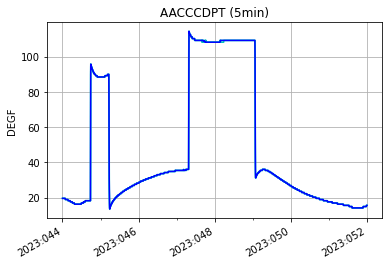

In [28]:
import plotly.io as pio
import plotly.express as px

fetch_eng.data_source.set('cxc') #maude
data5 = fetch_eng.Msid('aacccdpt', '2023:044', '2023:052')
#data5 = maude_query('aacccdpt', '2023:040', '2023:041')

# Technical Name
try: 
    tech_name = data5.tdb.technical_name
        
except KeyError:
    tech_name = "Not in TDB"
    
# Units
try:
    units = data5.unit
    print(units)
except KeyError:
    units = "None Found"

data5.iplot()


In [29]:
# Small check to see that the "all_good_ind" works:
print(len(data_anomaly['TSSMIN'].vals[all_good_ind]), len(data_anomaly['TSSMIN'].vals))

9882 9977
